In [1]:
import pandas as pd
import csv
import re
from datetime import datetime
from functools import reduce

In [2]:
def parseElasticSearchDate(timestamp):
    return datetime.strptime(timestamp, '%b %d, %Y @ %H:%M:%S.%f')

In [3]:
def csvToList(filename, valueKey, timestamp_key="@timestamp"):
    csvList = []
    with open(filename, 'r') as data:  
        for line in csv.DictReader(data):
            timestamp = parseElasticSearchDate(line[timestamp_key])
            csvList.append((timestamp, line[valueKey]))
    return csvList

In [4]:
def closestDatetime(metricList, date):
    return min(metricList, key=lambda x: abs(x[0] - date))

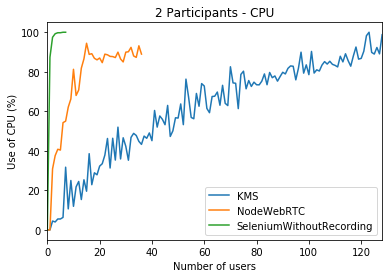

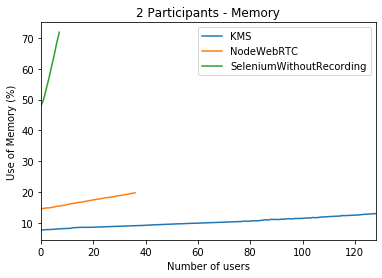

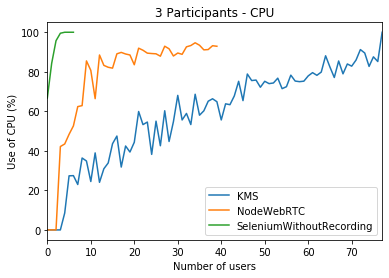

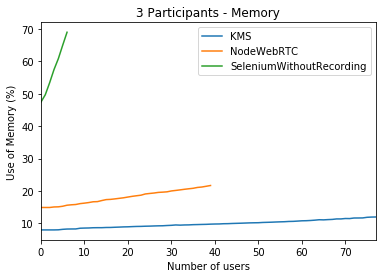

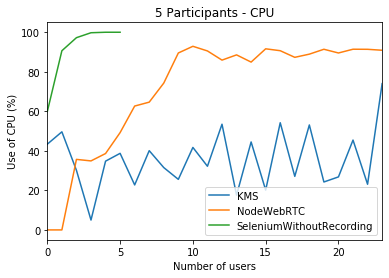

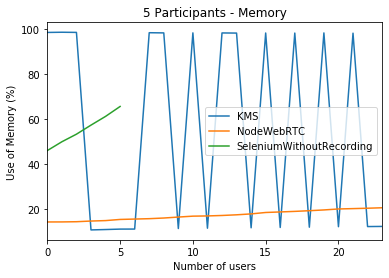

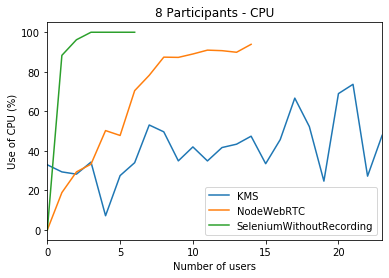

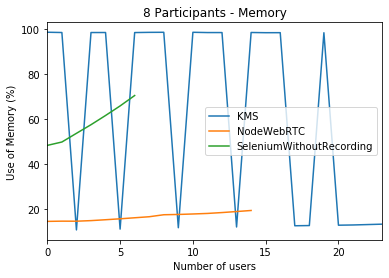

In [6]:
experiments = ["2", "3", "5", "8"]
# Approach with more users should be the first
approaches = ["KMS", "NodeWebRTC", "SeleniumWithoutRecording"]

for experiment in experiments:
    
    cpu_dfs = []
    mem_dfs = []
    
    for approach in approaches:
        cpu_path = '%s_Participants_Per_Session/%s/%s_%s_CPU.csv' %  (experiment, approach, experiment, approach)
        mem_path = '%s_Participants_Per_Session/%s/%s_%s_Mem.csv' %  (experiment, approach, experiment, approach)
        joined_path = '%s_Participants_Per_Session/%s/%s_%s_Joined.csv' %  (experiment, approach, experiment, approach)
        cpuList = csvToList(cpu_path, 'system.cpu.total.norm.pct')
        memList = csvToList(mem_path, 'system.memory.used.pct')
        
        unorderJoinedList = []
        with open(joined_path, 'r') as data:  
            for line in csv.DictReader(data):
                timestamp = parseElasticSearchDate(line["timestamp"])
                unorderJoinedList.append(timestamp)
        orderedJoinedList = sorted(unorderJoinedList)
        
        count = 0
        
        data = {
            "users": [],
            "cpu": [],
            "mem": []
        }
        
        for userJoinedTimeStamp in orderedJoinedList:
            count = count + 1
            closestCpuMetric = float(closestDatetime(cpuList, userJoinedTimeStamp)[1][:-1])
            closestMemMetric = float(closestDatetime(memList, userJoinedTimeStamp)[1][:-1])
            data["users"].append(count)
            data["cpu"].append(closestCpuMetric)
            data["mem"].append(closestMemMetric)
        
        cpu_data = {}
        cpu_data["Users"] = data["users"]
        cpu_data[approach] = data["cpu"]
        cpu_dfs.append(pd.DataFrame(cpu_data))
        
        mem_data = {}
        mem_data["Users"] = data["users"]
        mem_data[approach] = data["mem"]

        mem_dfs.append(pd.DataFrame(mem_data))
    
    # Generate CPU Chart
    cpu_df = reduce(lambda left,right: left.merge(right, how="left"), cpu_dfs)
    cpu_df = cpu_df.drop(columns=['Users'])
    ax = cpu_df.plot.line(title="%s Participants - CPU"%experiment)
    ax.set_ylabel("Use of CPU (%)")  
    ax.set_xlabel("Number of users")
    ax.figure.savefig("images/%s_Participants_Per_Session_CPU.pdf"%experiment, bbox_inches='tight')
    
    # Generate Mem
    mem_df = reduce(lambda left,right: left.merge(right, how="left"), mem_dfs)
    mem_df = mem_df.drop(columns=['Users'])
    ax = mem_df.plot.line(title="%s Participants - Memory"%experiment)
    ax.set_ylabel("Use of Memory (%)")
    ax.set_xlabel("Number of users")
    ax.figure.savefig("images/%s_Participants_Per_Session_Mem.pdf"%experiment, bbox_inches='tight')